In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


from pprint import pprint

Import data

In [72]:
def import_data():
    columns = ['age','sex','cp','trestbps','chol','fbs','restecg',
               'thalach','exang','oldpeak','slope','ca','thal','num']

    data = np.zeros((1, len(columns)))
    for file in ['../UCI_data/processed.va.csv', '../UCI_data/processed.switzerland.csv', 
                 '../UCI_data/processed.cleveland.csv', '../UCI_data/processed.hungarian.csv']:
        data = np.vstack((data, np.genfromtxt(file, delimiter=',')))
    data = data[1:]

    return pd.DataFrame(data=data, columns=columns, index=None)

Inspect data:

In [76]:
def plot(column):
    ax = sns.countplot(df[column])
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large' 
    )
    plt.locator_params(axis='x', nbins=10)
    plt.title(column)
    plt.figure()

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  4.0     140.0  260.0  0.0      1.0    112.0    1.0      3.0   
1  44.0  1.0  4.0     130.0  209.0  0.0      1.0    127.0    0.0      0.0   
2  60.0  1.0  4.0     132.0  218.0  0.0      1.0    140.0    1.0      1.5   
3  55.0  1.0  4.0     142.0  228.0  0.0      1.0    149.0    1.0      2.5   
4  66.0  1.0  3.0     110.0  213.0  1.0      2.0     99.0    1.0      1.3   
5  66.0  1.0  3.0     120.0    0.0  0.0      1.0    120.0    0.0     -0.5   
6  65.0  1.0  4.0     150.0  236.0  1.0      1.0    105.0    1.0      0.0   
7  60.0  1.0  3.0     180.0    0.0  0.0      1.0    140.0    1.0      1.5   
8  60.0  1.0  3.0     120.0    0.0  NaN      0.0    141.0    1.0      2.0   
9  60.0  1.0  2.0     160.0  267.0  1.0      1.0    157.0    0.0      0.5   

   slope  ca  thal  num  
0    2.0 NaN   NaN  2.0  
1    NaN NaN   NaN  0.0  
2    3.0 NaN   NaN  2.0  
3    1.0 NaN   NaN  1.0  
4    2.0 NaN   NaN  0.

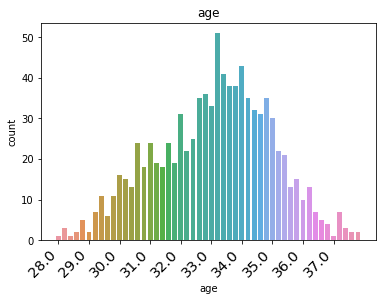

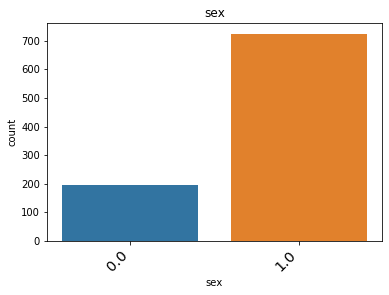

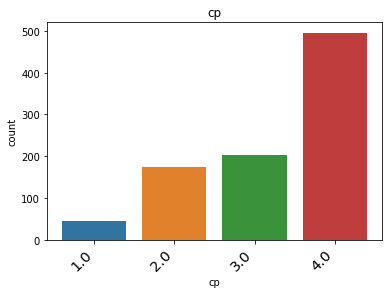

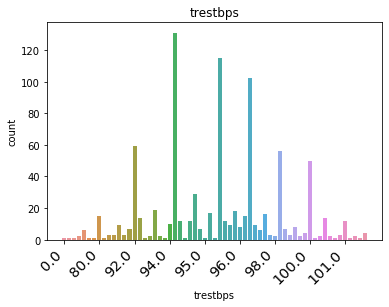

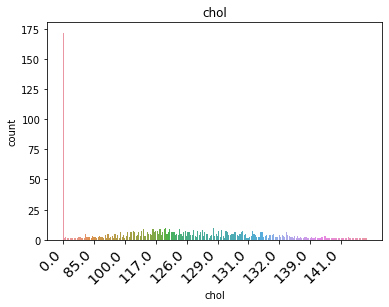

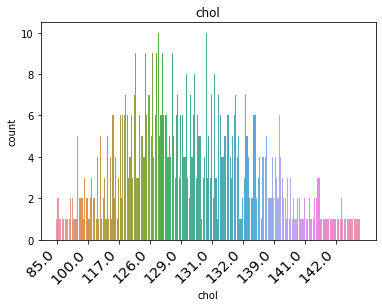

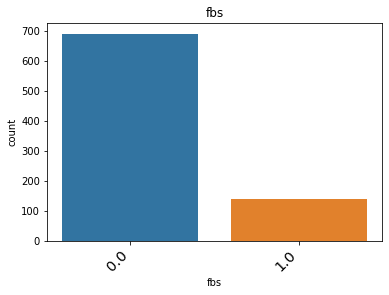

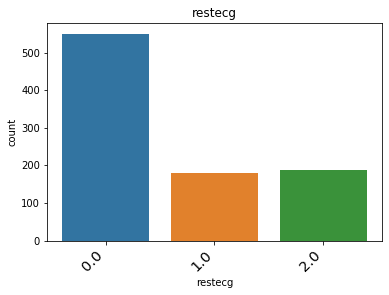

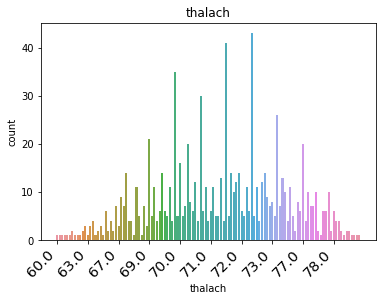

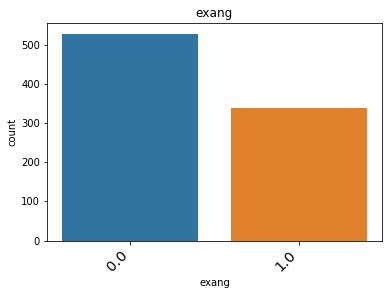

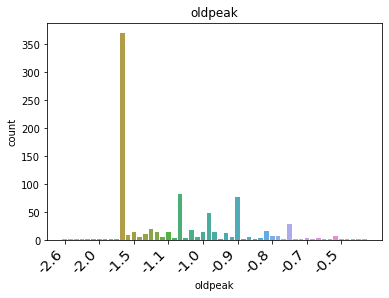

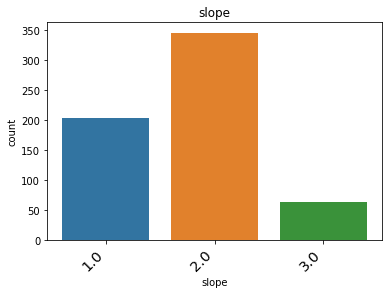

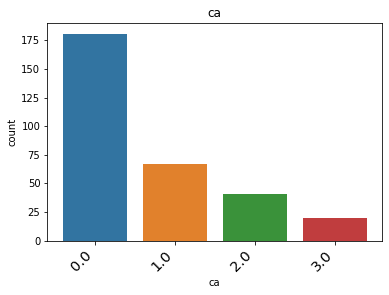

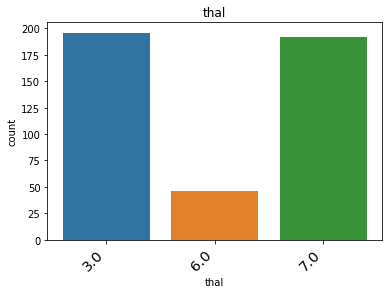

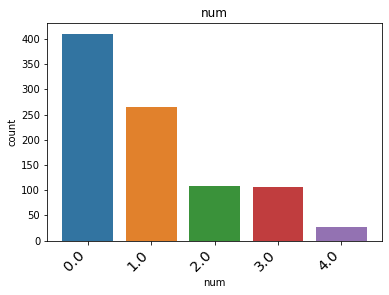

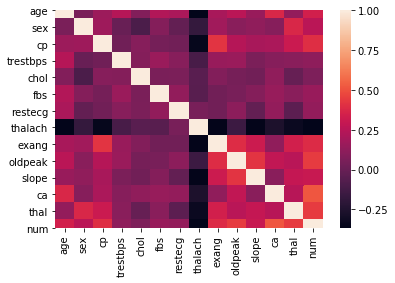

In [80]:
df = import_data()
pprint(df.head(10))
pprint(df.describe())
for column in df:
    plot(column)
    if column == 'chol':
        df.chol = df.chol.replace(0,np.nan)
        df.chol.dropna()
        plot(column)

# calculate the correlation matrix
corr = df.corr()

# plot the correlation heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)    

<img src="https://imgur.com/kHdbPbr.png">

Can Bootstrapping can be used for num 4?

Maybe, but there are certainly things to be careful of.

The sample size is incredible low and may not be representative for certain features:

<img src="https://imgur.com/Wl93hMY.png">

<img src="https://imgur.com/Yl1WyMI.png">

Very biased assessment, however, 13 samples is still very unsettling.

Trying with ca dropped then...

In [107]:
df_ca_drop = df.drop('ca', axis=1)

Cholesterol Problem:

<img src="https://imgur.com/vrrf3W2.png">
Since this makes no sense, "0" values must be missing values. 

In [59]:
df[df.chol == 0].head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
5,66.0,1.0,3.0,120.0,0.0,0.0,1.0,120.0,0.0,-0.5,1.0,NaN,NaN,0.0
7,60.0,1.0,3.0,180.0,0.0,0.0,1.0,140.0,1.0,1.5,2.0,NaN,NaN,0.0
8,60.0,1.0,3.0,120.0,0.0,NaN,0.0,141.0,1.0,2.0,1.0,NaN,NaN,3.0
11,59.0,1.0,4.0,140.0,0.0,0.0,1.0,117.0,1.0,1.0,2.0,NaN,NaN,1.0
12,62.0,1.0,4.0,110.0,0.0,0.0,0.0,120.0,1.0,0.5,2.0,NaN,3.0,1.0
13,63.0,1.0,3.0,NaN,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
14,57.0,1.0,4.0,128.0,0.0,1.0,1.0,148.0,1.0,1.0,2.0,NaN,NaN,1.0
18,63.0,1.0,4.0,126.0,0.0,0.0,1.0,120.0,0.0,1.5,3.0,NaN,NaN,0.0
19,60.0,1.0,4.0,152.0,0.0,0.0,1.0,118.0,1.0,0.0,NaN,NaN,7.0,0.0
20,58.0,1.0,4.0,116.0,0.0,0.0,0.0,124.0,0.0,1.0,1.0,NaN,NaN,2.0


Question:<br>Can the cholesterol values be reliably imputed in this dataset?

Import and process data

In [71]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = import_data().dropna()

X = df.drop(['chol'], axis=1)
y = np.array(df.chol[df.chol != 0]).reshape(-1,1)

#Standardize Data
x_scaler = StandardScaler()
y_scaler = StandardScaler()
x_scaler.fit(X)
y_scaler.fit(y)

X = x_scaler.transform(X)
y = y_scaler.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

In [72]:
lin_reg_model = LinearRegression().fit(X_train, y_train)

print("R squared is " + str(lin_reg_model.score(X_train, y_train)))

y_pred = lin_reg_model.predict(X_test)

R squared is 0.13857000927321894


This is a very low R value. Perhaps sklearn's multivariate feature imputation (uses Bayesian Ridge) can do better?

In [95]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit([[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]])

X_test = [[np.nan, 2], [6, np.nan], [np.nan, 6]]
# the model learns that the second feature is double the first
print(np.round(imp.transform(X_test)))

[[ 1.  2.]
 [ 6. 12.]
 [ 3.  6.]]


In [ ]:
df = import_data().dropna()

df.chol = df.chol.replace(0,np.NaN)

for column in df:
    df[column].dropna()

iter_impute_list = []
for i,each in enumerate(df.chol):
    iter_impute_list.append([df.chol[i],df.drop(chol, axis=1)[i]])

#estimator : estimator object, default=BayesianRidge()
imp = IterativeImputer(max_iter=10, random_state=0)
df_fit = pd.DataFrame(X_train,)
imp.fit(df)

Let's take another look at the data with the 0 values removed:

#### Turn erroneous 0 in chol to NaNs for now and dropping all...

In [172]:
df = import_data()

df.chol = df.chol.replace(0,np.nan)
df.oldpeak = df.oldpeak.replace(0,np.nan)

X = df.drop(['num'], axis=1).values.tolist()
y = df.num.values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

#Alternatively:
#train_dataset = dataset.sample(frac=0.8,random_state=0)
#test_dataset = dataset.drop(train_dataset.index)

Evalutating NN classifier properly within a nested cross-validation

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow import keras
tf.keras.__version__

'2.2.4-tf'

The Keras scikit wrapper is then required for this...

In [41]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [52]:
def keras_seq_model_one_ten(optimizer='rmsprop', init='glorot_uniform'):
    model = tf.keras.Sequential()
    # Adds a densely-connected layer with 14 units to the model:
    model.add(layers.Dense(13, input_dim=13, 
                           kernel_initializer=init, activation='relu'))

    #One "hidden layer" with 10 units
    model.add(layers.Dense(10, activation='relu'))
        
    # Add a softmax layer with 5 output units:
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def keras_seq_model(optimizer='rmsprop', init='glorot_uniform', hlayer_count=1):
    model = tf.keras.Sequential()
    
    # Add densely-connected layer with 13 units to the model:
    # Question: What is the difference between units input_dim?
    # units are 'dimensionality of the output space.' - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
    model.add(layers.Dense(units=13, input_dim=13, 
                           kernel_initializer=init, activation='relu'))

    #Add hidden layers 
    for i in range(hlayer_count):
        model.add(layers.Dense(10, activation='relu'))
        
    # Add a softmax layer with 5 output units:
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
df = import_data()
X = np.array(df.drop(['num'], axis=1).values.tolist())
y = np.array(df.num.values)

In [53]:
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
epochs = [50, 100, 150]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
model = KerasClassifier(build_fn=keras_seq_model_one_ten, epochs=150, batch_size=10, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, y)

C:\Users\demo\Miniconda3\envs\condaenv\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\demo\Miniconda3\envs\condaenv\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [54]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.446739 using {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 50, 'init': 'normal', 'optimizer': 'rmsprop'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 50, 'init': 'normal', 'optimizer': 'adam'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 50, 'init': 'uniform', 'optimizer': 'rmsprop'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 50, 'init': 'uniform', 'optimizer': 'adam'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 100, 'init': 'norma

In [57]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
hlayers_count = [1,2,5,10,20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init, hlayer_count=hlayers_count)
model = KerasClassifier(build_fn=keras_seq_model, epochs=150, batch_size=10, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, y)

C:\Users\demo\Miniconda3\envs\condaenv\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\demo\Miniconda3\envs\condaenv\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [58]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.446739 using {'batch_size': 5, 'epochs': 50, 'hlayer_count': 1, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 50, 'hlayer_count': 1, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 50, 'hlayer_count': 1, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 50, 'hlayer_count': 1, 'init': 'normal', 'optimizer': 'rmsprop'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 50, 'hlayer_count': 1, 'init': 'normal', 'optimizer': 'adam'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 50, 'hlayer_count': 1, 'init': 'uniform', 'optimizer': 'rmsprop'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 50, 'hlayer_count': 1, 'init': 'uniform', 'optimizer': 'adam'}
0.446739 (0.188634) with: {'batch_size': 5, 'epochs': 50, 'hlayer_count': 2, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.446739 (0.188634) with: {'

In [163]:
model = tf.keras.Sequential()
# Adds a densely-connected layer with 14 units to the model:
model.add(layers.Dense(13, activation='relu'))
# Add hidden layer:
ns = [2,5,10,20,50]
performances = []
for n in ns:
    for m in range(n):
        model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100)
    performances.append(f"Performance for {n} layers was: {model.evaluate(X_test,  y_test, verbose=2)}")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train on 136 samples
Epoch 1/100
136/136 [==============================] - 0s 3ms/sample - loss: 14.4484 - accuracy: 0.1250
Epoch 2/100
136/136 [==============================] - 0s 176us/sample - loss: 11.5956 - accuracy: 0.1103
Epoch 3/100
136/136 [==============================] - 0s 176us/sample - loss: 9.5165 - accuracy: 0.1324
Epoch 4/100
136/136 [==============================] - 0s 177us/sample - loss: 7.9305 - accuracy: 0.1250
Epoch 5/100
136/136 [==============================] - 0s 206us/sam

136/136 [==============================] - 0s 176us/sample - loss: 1.2681 - accuracy: 0.4926
Epoch 48/100
136/136 [==============================] - 0s 176us/sample - loss: 1.2708 - accuracy: 0.4706
Epoch 49/100
136/136 [==============================] - 0s 176us/sample - loss: 1.2564 - accuracy: 0.4926
Epoch 50/100
136/136 [==============================] - 0s 147us/sample - loss: 1.2668 - accuracy: 0.5000
Epoch 51/100
136/136 [==============================] - 0s 265us/sample - loss: 1.2565 - accuracy: 0.4926
Epoch 52/100
136/136 [==============================] - 0s 176us/sample - loss: 1.2592 - accuracy: 0.4706
Epoch 53/100
136/136 [==============================] - 0s 206us/sample - loss: 1.2526 - accuracy: 0.4559
Epoch 54/100
136/136 [==============================] - 0s 147us/sample - loss: 1.2481 - accuracy: 0.4779
Epoch 55/100
136/136 [==============================] - 0s 176us/sample - loss: 1.2431 - accuracy: 0.4779
Epoch 56/100
136/136 [==============================] - 0s 

136/136 [==============================] - 0s 206us/sample - loss: 1.0007 - accuracy: 0.5662
67/1 - 0s - loss: 0.7425 - accuracy: 0.5522
Train on 136 samples
Epoch 1/100
136/136 [==============================] - 2s 18ms/sample - loss: 1.6082 - accuracy: 0.3676
Epoch 2/100
136/136 [==============================] - 0s 235us/sample - loss: 1.6043 - accuracy: 0.4338
Epoch 3/100
136/136 [==============================] - 0s 235us/sample - loss: 1.6005 - accuracy: 0.4338
Epoch 4/100
136/136 [==============================] - 0s 294us/sample - loss: 1.5965 - accuracy: 0.4338
Epoch 5/100
136/136 [==============================] - 0s 235us/sample - loss: 1.5911 - accuracy: 0.4338
Epoch 6/100
136/136 [==============================] - 0s 235us/sample - loss: 1.5864 - accuracy: 0.4338
Epoch 7/100
136/136 [==============================] - 0s 294us/sample - loss: 1.5783 - accuracy: 0.4338
Epoch 8/100
136/136 [==============================] - 0s 265us/sample - loss: 1.5699 - accuracy: 0.4338
Epo

136/136 [==============================] - 0s 353us/sample - loss: 1.4276 - accuracy: 0.4338
Epoch 53/100
136/136 [==============================] - 0s 618us/sample - loss: 1.4286 - accuracy: 0.4338
Epoch 54/100
136/136 [==============================] - 0s 353us/sample - loss: 1.4285 - accuracy: 0.4338
Epoch 55/100
136/136 [==============================] - 0s 382us/sample - loss: 1.4282 - accuracy: 0.4338
Epoch 56/100
136/136 [==============================] - 0s 382us/sample - loss: 1.4277 - accuracy: 0.4338
Epoch 57/100
136/136 [==============================] - 0s 353us/sample - loss: 1.4264 - accuracy: 0.4338
Epoch 58/100
136/136 [==============================] - 0s 353us/sample - loss: 1.4305 - accuracy: 0.4338
Epoch 59/100
136/136 [==============================] - 0s 353us/sample - loss: 1.4304 - accuracy: 0.4338
Epoch 60/100
136/136 [==============================] - 0s 353us/sample - loss: 1.4285 - accuracy: 0.4338
Epoch 61/100
136/136 [==============================] - 0s 

In [165]:
pprint(performances)

['Performance for 2 layers was: [1.2972903607496575, 0.47761193]',
 'Performance for 5 layers was: [1.0598468504734893, 0.53731346]',
 'Performance for 10 layers was: [1.0269287895800463, 0.5522388]',
 'Performance for 20 layers was: [1.0313029903084485, 0.53731346]',
 'Performance for 50 layers was: [1.412776774434901, 0.46268657]']


With different neuron activation:

In [178]:
model = tf.keras.Sequential()
# Adds a densely-connected layer with 14 units to the model:
model.add(layers.Dense(13, activation='sigmoid'))
# Add hidden layer:
ns = [1,2,5,10,20,50]
performances = []
for n in ns:
    for m in range(n):
        model.add(layers.Dense(10, activation='sigmoid'))
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100)
    performances.append(f"Performance for {n} layers was: {model.evaluate(X_test,  y_test, verbose=2)}")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train on 616 samples
Epoch 1/100
616/616 [==============================] - 0s 594us/sample - loss: nan - accuracy: 0.4416
Epoch 2/100
616/616 [==============================] - 0s 78us/sample - loss: nan - accuracy: 0.4416
Epoch 3/100
616/616 [==============================] - 0s 71us/sample - loss: nan - accuracy: 0.4416
Epoch 4/100
616/616 [==============================] - 0s 78us/sample - loss: nan - accuracy: 0.4416
Epoch 5/100
616/616 [==============================] - 0s 91us/sample - loss: nan 

616/616 [==============================] - 0s 84us/sample - loss: nan - accuracy: 0.4416
Epoch 75/100
616/616 [==============================] - 0s 84us/sample - loss: nan - accuracy: 0.4416
Epoch 76/100
616/616 [==============================] - 0s 84us/sample - loss: nan - accuracy: 0.4416
Epoch 77/100
616/616 [==============================] - 0s 65us/sample - loss: nan - accuracy: 0.4416
Epoch 78/100
616/616 [==============================] - 0s 65us/sample - loss: nan - accuracy: 0.4416
Epoch 79/100
616/616 [==============================] - 0s 65us/sample - loss: nan - accuracy: 0.4416
Epoch 80/100
616/616 [==============================] - 0s 65us/sample - loss: nan - accuracy: 0.4416
Epoch 81/100
616/616 [==============================] - 0s 65us/sample - loss: nan - accuracy: 0.4416
Epoch 82/100
616/616 [==============================] - 0s 65us/sample - loss: nan - accuracy: 0.4416
Epoch 83/100
616/616 [==============================] - 0s 65us/sample - loss: nan - accuracy: 

616/616 [==============================] - 0s 156us/sample - loss: nan - accuracy: 0.4416
Epoch 33/100
616/616 [==============================] - 0s 130us/sample - loss: nan - accuracy: 0.4416
Epoch 34/100
616/616 [==============================] - 0s 123us/sample - loss: nan - accuracy: 0.4416
Epoch 35/100
616/616 [==============================] - 0s 84us/sample - loss: nan - accuracy: 0.4416
Epoch 36/100
616/616 [==============================] - 0s 84us/sample - loss: nan - accuracy: 0.4416
Epoch 37/100
616/616 [==============================] - 0s 110us/sample - loss: nan - accuracy: 0.4416
Epoch 38/100
616/616 [==============================] - 0s 91us/sample - loss: nan - accuracy: 0.4416
Epoch 39/100
616/616 [==============================] - 0s 84us/sample - loss: nan - accuracy: 0.4416
Epoch 40/100
616/616 [==============================] - 0s 97us/sample - loss: nan - accuracy: 0.4416
Epoch 41/100
616/616 [==============================] - 0s 104us/sample - loss: nan - accur

616/616 [==============================] - 0s 123us/sample - loss: nan - accuracy: 0.4416
Epoch 91/100
616/616 [==============================] - 0s 117us/sample - loss: nan - accuracy: 0.4416
Epoch 92/100
616/616 [==============================] - 0s 117us/sample - loss: nan - accuracy: 0.4416
Epoch 93/100
616/616 [==============================] - 0s 110us/sample - loss: nan - accuracy: 0.4416
Epoch 94/100
616/616 [==============================] - 0s 162us/sample - loss: nan - accuracy: 0.4416
Epoch 95/100
616/616 [==============================] - 0s 162us/sample - loss: nan - accuracy: 0.4416
Epoch 96/100
616/616 [==============================] - 0s 136us/sample - loss: nan - accuracy: 0.4416
Epoch 97/100
616/616 [==============================] - 0s 149us/sample - loss: nan - accuracy: 0.4416
Epoch 98/100
616/616 [==============================] - 0s 156us/sample - loss: nan - accuracy: 0.4416
Epoch 99/100
616/616 [==============================] - 0s 130us/sample - loss: nan - 

616/616 [==============================] - 0s 273us/sample - loss: nan - accuracy: 0.4416
Epoch 47/100
616/616 [==============================] - 0s 273us/sample - loss: nan - accuracy: 0.4416
Epoch 48/100
616/616 [==============================] - 0s 558us/sample - loss: nan - accuracy: 0.4416
Epoch 49/100
616/616 [==============================] - 0s 258us/sample - loss: nan - accuracy: 0.4416
Epoch 50/100
616/616 [==============================] - 0s 318us/sample - loss: nan - accuracy: 0.4416
Epoch 51/100
616/616 [==============================] - 0s 331us/sample - loss: nan - accuracy: 0.4416
Epoch 52/100
616/616 [==============================] - 0s 364us/sample - loss: nan - accuracy: 0.4416
Epoch 53/100
616/616 [==============================] - 0s 415us/sample - loss: nan - accuracy: 0.4416
Epoch 54/100
616/616 [==============================] - 0s 351us/sample - loss: nan - accuracy: 0.4416
Epoch 55/100
616/616 [==============================] - 0s 292us/sample - loss: nan - 

In [179]:
print("With sigmoid activtation:")
pprint(performances)

With sigmoid activtation:
['Performance for 1 layers was: [nan, 0.45723686]',
 'Performance for 2 layers was: [nan, 0.45723686]',
 'Performance for 5 layers was: [nan, 0.45723686]',
 'Performance for 10 layers was: [nan, 0.45723686]',
 'Performance for 20 layers was: [nan, 0.45723686]',
 'Performance for 50 layers was: [nan, 0.45723686]']


<img src="https://imgur.com/eD9XE3q.png">

<img src="https://imgur.com/1PiFcPL.png">
<center> <font size=2> image source = https://machinelearningmastery.com/why-training-a-neural-network-is-hard/

<img src="https://imgur.com/mrXnncR.png">

In [4]:
df = import_data()

df.chol = df.chol.replace(0,np.nan)
df.oldpeak = df.oldpeak.replace(0,np.nan)

X = df.drop(['num'], axis=1).values.tolist()
y = df.num.values.tolist()

Proper way to assess performance is not accuracy. Confusion matrix is better. Also, keeping in mind expecting values for respective classes is key.

In [118]:
from sklearn import metrics

df = import_data()

df.chol = df.chol.replace(0,np.nan)
df.oldpeak = df.oldpeak.replace(0,np.nan)

df = df.dropna()

model = keras_seq_model_one_ten()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

y_pred = model.predict(X_test)
matrix = metrics.confusion_matrix(y_test, y_pred)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').